# Output Preparation for the Nord_H2ub Spine Model

This jupyter notebook contains all routines for the preparation of the input data sources into a input data file for the model in Spine.

Authors: Johannes Giehl (jfg.eco@cbs.dk), Dana J. Hentschel (djh.eco@cbs.dk)

## General settings

### Packages:

In [2]:
import pandas as pd
import os
import openpyxl
import numpy as np

### define variables

In [10]:
excel_name = 'output_last_run'

### File paths:

In [3]:
#parent folder
parent_folder = '../02_basic_energy_model/.spinetoolbox/items/exporter/output'
folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]
if not folders:
    print("No folders found.")
else:
    latest_folder = max(folders, key=lambda x: os.path.getmtime(os.path.join(parent_folder, x)))
    latest_folder_path = os.path.join(parent_folder, latest_folder)
latest_folder_path = latest_folder_path.replace('\\', '/')
folder_path = latest_folder_path
folder_path += '/'

#prepared input data
output_file_path = '../02_output_data/01_basic_energy_model_outputs/'

In [4]:
#set name of the relevant files
#input file
output_old = 'Output_exported.xlsx'

## Workflow of the data preparation

### Data Import

In [5]:
df_output = pd.read_excel(folder_path + output_old)
df_PV_prices = pd.read_excel('../01_input_data/02_input_prepared/Maersk_Example_Input_prepared.xlsx', sheet_name='Energy_prices')

In [6]:
selected_column_name = None
for column_index in range(len(df_output.columns)):
    if df_output.iloc[0, column_index] == 'power_line_Wholesale_Kasso' \
        and df_output.iloc[1, column_index] == 'to_node' \
        and df_output.iloc[2, column_index] == 'Power_Wholesale':
        selected_column_name = df_output.columns[column_index]
        break

if selected_column_name:
    df_output['proceeds from PV'] = df_output[selected_column_name].iloc[3:] * df_PV_prices['Power_Wholesale_Out'].iloc[4]
else:
    print("Column with specified headers not found in output.")

In [7]:
total_costs = df_output['total_costs'].iloc[3]
total_proceeds = df_output['proceeds from PV'].sum()
adjusted_costs = total_costs - total_proceeds
df_output['adjusted costs'] = np.nan
df_output.at[3, 'adjusted costs'] = adjusted_costs

### Creating one combined excel and export

In [11]:
with pd.ExcelWriter(output_file_path + excel_name + '.xlsx') as writer:
    df_output.to_excel(writer, sheet_name='Total costs')

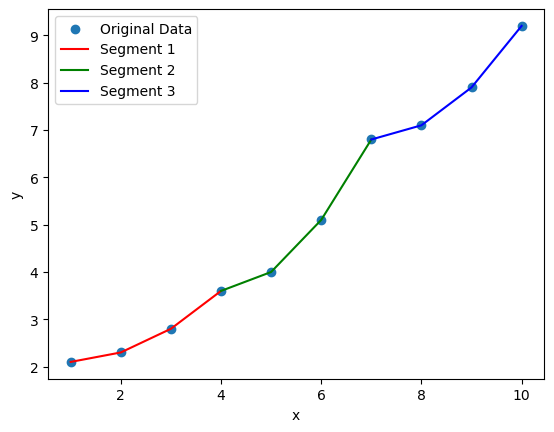

Segment 1:
   x    y
0  1  2.1
1  2  2.3
2  3  2.8
3  4  3.6
Start point: (1, 2.1)
End point: (4, 3.6)
Average value: 2.7
Segment 2:
   x    y
3  4  3.6
4  5  4.0
5  6  5.1
6  7  6.8
Start point: (4, 3.6)
End point: (7, 6.8)
Average value: 4.875
Segment 3:
    x    y
6   7  6.8
7   8  7.1
8   9  7.9
9  10  9.2
Start point: (7, 6.8)
End point: (10, 9.2)
Average value: 7.749999999999999


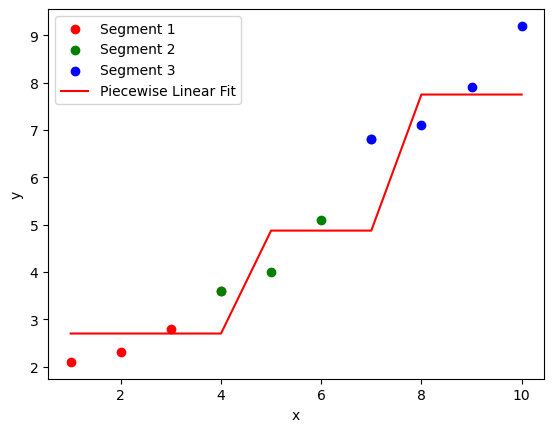

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Sample DataFrame (replace with your data)
data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Define break points manually or programmatically
breaks = [1, 4, 7, 10]  # You can adjust these break points as needed

# Create linear interpolations for each segment
segments = []
for i in range(len(breaks) - 1):
    mask = (df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])
    segment_df = df[mask]
    f = interp1d(segment_df['x'], segment_df['y'], kind='linear', fill_value="extrapolate")
    segments.append((segment_df['x'], segment_df['y'], f))

# Plot the original data and the piecewise linear fit
plt.scatter(df['x'], df['y'], label='Original Data')

# Plot each segment
colors = ['red', 'green', 'blue']
for i, (segment_x, segment_y, f) in enumerate(segments):
    plt.plot(segment_x, f(segment_x), label=f'Segment {i + 1}', color=colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Function to split data into linear segments and calculate segment info
def split_curve(df, breaks):
    segments = []
    segment_info = []
    for i in range(len(breaks) - 1):
        segment = df[(df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])]
        start_point = (segment['x'].iloc[0], segment['y'].iloc[0])
        end_point = (segment['x'].iloc[-1], segment['y'].iloc[-1])
        average_value = segment['y'].mean()
        segment_info.append({
            'start_point': start_point,
            'end_point': end_point,
            'average_value': average_value
        })
        segments.append(segment)
    return segments, segment_info

# Split the curve and get segment information
segments, segment_info = split_curve(df, breaks)
for i, segment in enumerate(segments):
    print(f"Segment {i + 1}:")
    print(segment)
    print(f"Start point: {segment_info[i]['start_point']}")
    print(f"End point: {segment_info[i]['end_point']}")
    print(f"Average value: {segment_info[i]['average_value']}")

# Optional: Plot each segment
for i, segment in enumerate(segments):
    plt.scatter(segment['x'], segment['y'], label=f'Segment {i + 1}', color=colors[i])
plt.plot(df['x'], df.apply(lambda row: segment_info[[i for i in range(len(breaks)-1) if breaks[i] <= row['x'] <= breaks[i+1]][0]]['average_value'], axis=1), label='Piecewise Linear Fit', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


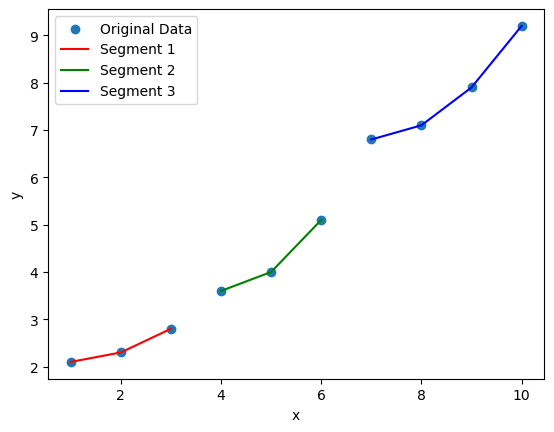

Segment 1:
   x    y
0  1  2.1
1  2  2.3
2  3  2.8
Start point: (1, 2.1)
End point: (3, 2.8)
Average value: 2.4
Segment 2:
   x    y
3  4  3.6
4  5  4.0
5  6  5.1
Start point: (4, 3.6)
End point: (6, 5.1)
Average value: 4.233333333333333
Segment 3:
    x    y
6   7  6.8
7   8  7.1
8   9  7.9
9  10  9.2
Start point: (7, 6.8)
End point: (10, 9.2)
Average value: 7.749999999999999


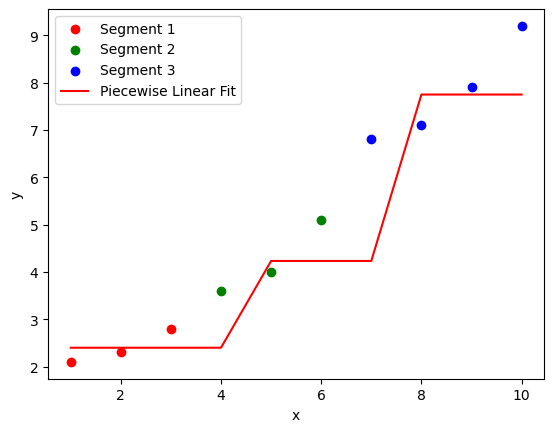

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Sample DataFrame (replace with your data)
data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Define the number of segments
num_segments = 3

# Calculate break points based on the number of segments
x_min, x_max = df['x'].min(), df['x'].max()
breaks = np.linspace(x_min, x_max, num_segments + 1)

# Create linear interpolations for each segment
segments = []
for i in range(len(breaks) - 1):
    mask = (df['x'] >= breaks[i]) & (df['x'] < breaks[i + 1])
    if i == len(breaks) - 2:
        mask = (df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])  # Include the last point in the final segment
    segment_df = df[mask]
    f = interp1d(segment_df['x'], segment_df['y'], kind='linear', fill_value="extrapolate")
    segments.append((segment_df['x'], segment_df['y'], f))

# Plot the original data and the piecewise linear fit
plt.scatter(df['x'], df['y'], label='Original Data')

# Plot each segment
colors = ['red', 'green', 'blue']
for i, (segment_x, segment_y, f) in enumerate(segments):
    plt.plot(segment_x, f(segment_x), label=f'Segment {i + 1}', color=colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Function to split data into linear segments and calculate segment info
def split_curve(df, breaks):
    segments = []
    segment_info = []
    for i in range(len(breaks) - 1):
        mask = (df['x'] >= breaks[i]) & (df['x'] < breaks[i + 1])
        if i == len(breaks) - 2:
            mask = (df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])  # Include the last point in the final segment
        segment = df[mask]
        start_point = (segment['x'].iloc[0], segment['y'].iloc[0])
        end_point = (segment['x'].iloc[-1], segment['y'].iloc[-1])
        average_value = segment['y'].mean()
        segment_info.append({
            'start_point': start_point,
            'end_point': end_point,
            'average_value': average_value
        })
        segments.append(segment)
    return segments, segment_info

# Split the curve and get segment information
segments, segment_info = split_curve(df, breaks)
for i, segment in enumerate(segments):
    print(f"Segment {i + 1}:")
    print(segment)
    print(f"Start point: {segment_info[i]['start_point']}")
    print(f"End point: {segment_info[i]['end_point']}")
    print(f"Average value: {segment_info[i]['average_value']}")

# Optional: Plot each segment
for i, segment in enumerate(segments):
    plt.scatter(segment['x'], segment['y'], label=f'Segment {i + 1}', color=colors[i])
plt.plot(df['x'], df.apply(lambda row: segment_info[[i for i in range(len(breaks)-1) if breaks[i] <= row['x'] <= breaks[i+1]][0]]['average_value'], axis=1), label='Piecewise Linear Fit', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Segment 1:
   x    y
0  1  2.1
1  2  2.3
Start point: (1, 2.1)
End point: (2, 2.3)
Average value: 2.2
Segment 2:
   x    y
2  3  2.8
3  4  3.6
Start point: (3, 2.8)
End point: (4, 3.6)
Average value: 3.2
Segment 3:
   x    y
4  5  4.0
5  6  5.1
Start point: (5, 4.0)
End point: (6, 5.1)
Average value: 4.55
Segment 4:
   x    y
6  7  6.8
7  8  7.1
Start point: (7, 6.8)
End point: (8, 7.1)
Average value: 6.949999999999999
Segment 5:
    x    y
8   9  7.9
9  10  9.2
Start point: (9, 7.9)
End point: (10, 9.2)
Average value: 8.55


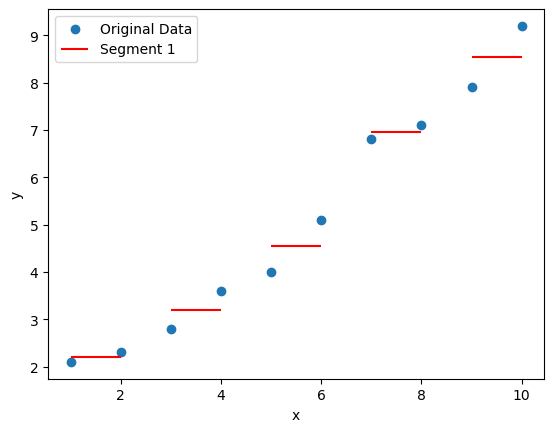

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Define the number of segments
num_segments = 5

# Calculate break points based on the number of segments
x_min, x_max = df['x'].min(), df['x'].max()
breaks = np.linspace(x_min, x_max, num_segments + 1)

# Create a function to split the curve and calculate segment info
def split_curve(df, breaks):
    segments = []
    segment_info = []
    for i in range(len(breaks) - 1):
        mask = (df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])
        segment = df[mask]
        start_point = (segment['x'].iloc[0], segment['y'].iloc[0])
        end_point = (segment['x'].iloc[-1], segment['y'].iloc[-1])
        average_value = segment['y'].mean()
        segment_info.append({
            'start_point': start_point,
            'end_point': end_point,
            'average_value': average_value
        })
        segments.append(segment)
    return segments, segment_info

# Split the curve and get segment information
segments, segment_info = split_curve(df, breaks)
for i, segment in enumerate(segments):
    print(f"Segment {i + 1}:")
    print(segment)
    print(f"Start point: {segment_info[i]['start_point']}")
    print(f"End point: {segment_info[i]['end_point']}")
    print(f"Average value: {segment_info[i]['average_value']}")

# Plot the original data
plt.scatter(df['x'], df['y'], label='Original Data')

# Plot each segment as a horizontal line (stair plot)
for i, info in enumerate(segment_info):
    plt.hlines(y=info['average_value'], xmin=info['start_point'][0], xmax=info['end_point'][0], colors='r', label=f'Segment {i + 1}' if i == 0 else "")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Segment 1:
   x    y
0  1  2.1
1  2  2.3
Start point: (1, 2.1)
End point: (2, 2.3)
Average value: 2.2
Segment 2:
   x    y
2  3  2.8
3  4  3.6
Start point: (3, 2.8)
End point: (4, 3.6)
Average value: 3.2
Segment 3:
   x    y
4  5  4.0
5  6  5.1
Start point: (5, 4.0)
End point: (6, 5.1)
Average value: 4.55
Segment 4:
   x    y
6  7  6.8
7  8  7.1
Start point: (7, 6.8)
End point: (8, 7.1)
Average value: 6.949999999999999
Segment 5:
    x    y
8   9  7.9
9  10  9.2
Start point: (9, 7.9)
End point: (10, 9.2)
Average value: 8.55


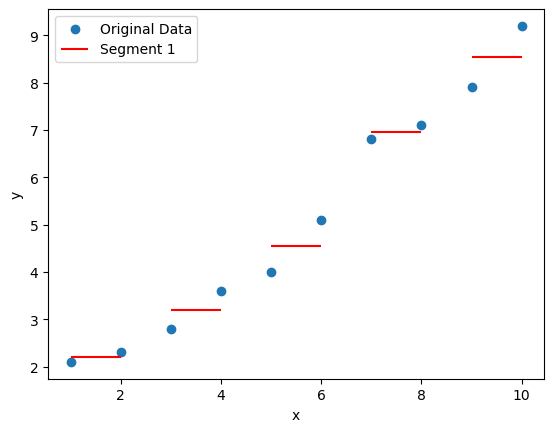

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Define the number of segments
num_segments = 5

# Calculate break points based on the number of segments
x_min, x_max = df['x'].min(), df['x'].max()
breaks = np.linspace(x_min, x_max, num_segments + 1)

# Create a function to split the curve and calculate segment info
def split_curve(df, breaks):
    segments = []
    segment_info = []
    for i in range(len(breaks) - 1):
        mask = (df['x'] >= breaks[i]) & (df['x'] < breaks[i + 1])
        if i == len(breaks) - 2:
            mask = (df['x'] >= breaks[i]) & (df['x'] <= breaks[i + 1])  # Include the last point in the final segment
        segment = df[mask]
        if not segment.empty:
            start_point = (segment['x'].iloc[0], segment['y'].iloc[0])
            end_point = (segment['x'].iloc[-1], segment['y'].iloc[-1])
            average_value = segment['y'].mean()
            segment_info.append({
                'start_point': start_point,
                'end_point': end_point,
                'average_value': average_value
            })
            segments.append(segment)
    return segments, segment_info

# Split the curve and get segment information
segments, segment_info = split_curve(df, breaks)
for i, segment in enumerate(segments):
    print(f"Segment {i + 1}:")
    print(segment)
    print(f"Start point: {segment_info[i]['start_point']}")
    print(f"End point: {segment_info[i]['end_point']}")
    print(f"Average value: {segment_info[i]['average_value']}")

# Plot the original data
plt.scatter(df['x'], df['y'], label='Original Data')

# Plot each segment as a horizontal line (stair plot)
for i, info in enumerate(segment_info):
    plt.hlines(y=info['average_value'], xmin=info['start_point'][0], xmax=info['end_point'][0], colors='r', label=f'Segment {i + 1}' if i == 0 else "")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Segment 1:
   x    y
0  1  2.1
1  2  2.3
2  3  2.8
Start point: (1, 2.1)
End point: (3, 2.8)
Average value: 2.4
Segment 2:
   x    y
3  4  3.6
4  5  4.0
5  6  5.1
Start point: (4, 3.6)
End point: (6, 5.1)
Average value: 4.233333333333333
Segment 3:
   x    y
6  7  6.8
7  8  7.1
8  9  7.9
Start point: (7, 6.8)
End point: (9, 7.9)
Average value: 7.266666666666666


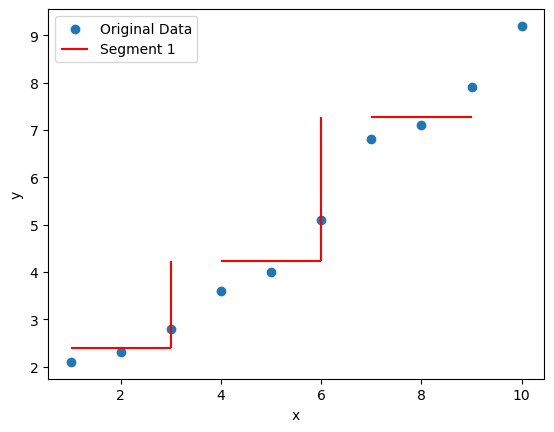

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Define the number of segments
num_segments = 3

# Calculate the segment borders
x_min, x_max = df['x'].min(), df['x'].max()
segment_size = (x_max - x_min) / num_segments
segment_borders = [x_min + i * segment_size for i in range(num_segments)] + [x_max]

# Create a function to split the curve and calculate segment info
def split_curve(df, segment_borders):
    segments = []
    segment_info = []
    for i in range(len(segment_borders) - 1):
        mask = (df['x'] >= segment_borders[i]) & (df['x'] < segment_borders[i + 1])
        segment = df[mask]
        if not segment.empty:
            start_point = (segment['x'].iloc[0], segment['y'].iloc[0])
            end_point = (segment['x'].iloc[-1], segment['y'].iloc[-1])
            average_value = segment['y'].mean()
            segment_info.append({
                'start_point': start_point,
                'end_point': end_point,
                'average_value': average_value
            })
            segments.append(segment)
    return segments, segment_info

# Split the curve and get segment information
segments, segment_info = split_curve(df, segment_borders)
for i, segment in enumerate(segments):
    print(f"Segment {i + 1}:")
    print(segment)
    print(f"Start point: {segment_info[i]['start_point']}")
    print(f"End point: {segment_info[i]['end_point']}")
    print(f"Average value: {segment_info[i]['average_value']}")

# Plot the original data
plt.scatter(df['x'], df['y'], label='Original Data')

# Plot each segment as a horizontal line (stair plot)
for i, info in enumerate(segment_info):
    plt.hlines(y=info['average_value'], xmin=info['start_point'][0], xmax=info['end_point'][0], colors='r', label=f'Segment {i + 1}' if i == 0 else "")
    if i < len(segment_info) - 1:  # Add vertical line to connect segments
        plt.vlines(x=info['end_point'][0], ymin=info['average_value'], ymax=segment_info[i + 1]['average_value'], colors='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


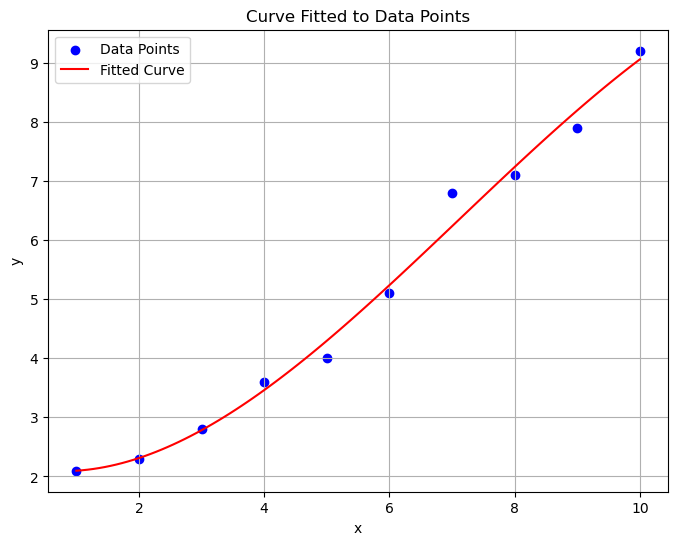

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [2.1, 2.3, 2.8, 3.6, 4.0, 5.1, 6.8, 7.1, 7.9, 9.2]
}
df = pd.DataFrame(data)

# Fitting a polynomial curve
coefficients = np.polyfit(df['x'], df['y'], 3)  # Change the degree (3) as needed
poly_function = np.poly1d(coefficients)

# Generating points for the curve
x_values = np.linspace(df['x'].min(), df['x'].max(), 100)
y_values = poly_function(x_values)

# Plotting the data points and the curve
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], color='blue', label='Data Points')
plt.plot(x_values, y_values, color='red', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitted to Data Points')
plt.legend()
plt.grid(True)
plt.show()


Segment 1 (x-axis range 1.00 to 4.00): Average y-value = 2.70
Segment 2 (x-axis range 4.00 to 7.00): Average y-value = 4.88
Segment 3 (x-axis range 7.00 to 10.00): Average y-value = 7.75


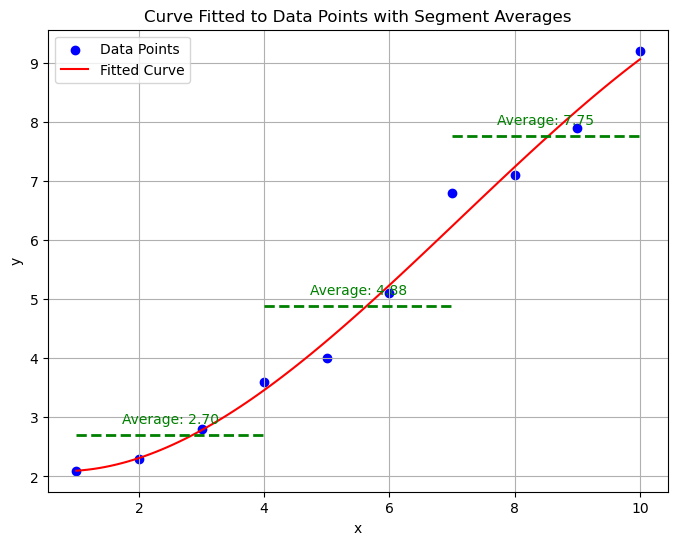

In [28]:
# Dividing the x-axis range into segments
des_segments = 3 #set by user
num_segments = des_segments - 1
segment_ranges = np.linspace(df['x'].min(), df['x'].max(), num_segments + 1)

# Calculating the average for each segment
segment_averages = []
segment_x_values = []
for i in range(num_segments):
    segment_mask = (df['x'] >= segment_ranges[i]) & (df['x'] <= segment_ranges[i + 1])
    segment_data = df[segment_mask]
    segment_average = segment_data['y'].mean()
    segment_averages.append(segment_average)
    segment_x_values.append((segment_ranges[i], segment_ranges[i + 1]))

# Printing the segment ranges and averages
for i, (x_start, x_end) in enumerate(segment_x_values):
    print(f"Segment {i + 1} (x-axis range {x_start:.2f} to {x_end:.2f}): Average y-value = {segment_averages[i]:.2f}")
# Plotting the data points and the curve
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], color='blue', label='Data Points')
plt.plot(x_values, y_values, color='red', label='Fitted Curve')

# Plotting segment averages
for i, (x_start, x_end) in enumerate(segment_x_values):
    plt.plot([x_start, x_end], [segment_averages[i], segment_averages[i]], color='green', linestyle='--', linewidth=2)
    plt.text((x_start + x_end) / 2, segment_averages[i] + 0.2, f"Average: {segment_averages[i]:.2f}", color='green', ha='center')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitted to Data Points with Segment Averages')
plt.legend()
plt.grid(True)
plt.show()
